# Federated Variational Autoencoders
Here, an example of latent analysis using federated learning and Variational autoencoders.In this example we will illustrate the usage for an iid scenario.

In [3]:
import copy
from tqdm.auto import tqdm

import torch
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms

In [4]:
N_CENTERS = 4
N_ROUNDS = 3   # Number of iterations between all the centers training and the aggregation process.

N_EPOCHS = 15   # Number of epochs before aggregating
BATCH_SIZE = 48
LR = 1e-3       # Learning rate

We define a set of functions to distribute our dataset across multiple centers (`split_iid`) and for doing federated averaging (`federated_averaging`).

In [5]:
def split_iid(dataset, n_centers):
    """ Split PyTorch dataset randomly into n_centers """
    n_obs_per_center = [len(dataset) // n_centers for _ in range(n_centers)]
    return random_split(dataset, n_obs_per_center)

In [6]:
def federated_averaging(models, n_obs_per_client):
    assert len(models) > 0, 'An empty list of models was passed.'
    assert len(n_obs_per_client) == len(models), 'List with number of observations must have ' \
                                                 'the same number of elements that list of models.'

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

## Federating dataset

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0,), (1,))])
dataset = datasets.MNIST('~/data/', train=True, download=True, transform=transform)

Now, `federated_dataset` is a list of subsets of the main dataset.

In [8]:
federated_dataset = split_iid(dataset, n_centers=N_CENTERS)
print('Number of centers:', len(federated_dataset))

Number of centers: 4


## Defining and distributing a model: Variational Autoencoder
In this excercise we will use the Multi-channel Variational Autoencoder proposed by Antelmi _et_ al.

In [15]:
!pip install -q git+https://gitlab.inria.fr/epione_ML/mcvae.git

In [17]:
from mcvae.models import Mcvae, ThreeLayersVAE, VAE

First, it is necessary to define a model.

In [56]:
N_FEATURES = 784  # Number of pixels in MNIST

In [62]:
dummy_data = [torch.zeros(1, N_FEATURES)]  # Dummy data to initialize the input layer size
lat_dim = 3  # Size of the latent space for this autoencoder
vae_class = ThreeLayersVAE  # Architecture of the autoencoder (VAE: Single layer)

In [68]:
model = Mcvae(data=dummy_data, lat_dim=lat_dim, vaeclass=vae_class)
model.optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
model.init_loss()

Now replicate a copy of the models across different centers.

In [64]:
models = [copy.deepcopy(model) for _ in range(N_CENTERS)]
n_obs_per_client = [len(client_data) for client_data in federated_dataset]

Train in a federated fashion

In [65]:
def get_data(subset, shuffle=True):
    """ Extracts data from a Subset torch dataset in the form of a tensor"""
    loader = DataLoader(subset, batch_size=len(subset), shuffle=shuffle)
    return iter(loader).next()

In [69]:
init_params = model.state_dict()
for round_i in range(N_ROUNDS):
    for client_dataset, client_model in zip(federated_dataset, models):
        # Load client data in the form of a tensor
        X, y = get_data(client_dataset)
        client_model.data = [X.view(-1, N_FEATURES)]  # Set data attribute in client's model (list wraps the number of channels)

        # Load client's model parameters and train
        client_model.load_state_dict(init_params)
        client_model.optimize(epochs=N_EPOCHS, data=client_model.data)
        
    # Aggregate models using federated averaging
    trained_model = federated_averaging(models, n_obs_per_client)
    init_params = trained_model.state_dict()

====> Epoch:    0/1 (0%)	Loss: 553.9203	LL: -553.9184	KL: 0.0019	LL/KL: -285153.3064
====> Epoch:    0/1 (0%)	Loss: 555.2447	LL: -555.2427	KL: 0.0019	LL/KL: -286318.8150
====> Epoch:    0/1 (0%)	Loss: 556.8881	LL: -556.8862	KL: 0.0019	LL/KL: -288700.3656


## Results visualization
Using the final parameters we can evaluate the performance of the model by visualizing the testing set onto the latent space.

In [88]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [77]:
dataset_test = datasets.MNIST('~/data/', train=False, download=True)
X_test, y_test = [dataset_test.data.view(-1, N_FEATURES).float()], dataset_test.targets

In [78]:
Z_test = np.hstack([z.loc.detach().numpy() for z in trained_model.encode(X_test)])

In [86]:
col_names = [f'$Z_{i}$' for i in range(Z_test.shape[1])]
latent_df = pd.DataFrame(Z_test, columns=col_names)
latent_df['label'] = y_test
latent_df['label'] = latent_df['label'].astype('category')
latent_df.head()

,$Z_0$,$Z_1$,$Z_2$,label
0,72.332016,50.513977,-124.070969,7
1,91.870499,69.231125,-174.331635,2
2,37.161240,28.966492,-77.322395,1
3,141.213501,97.569939,-217.210663,0
4,87.379990,55.159897,-128.888428,4


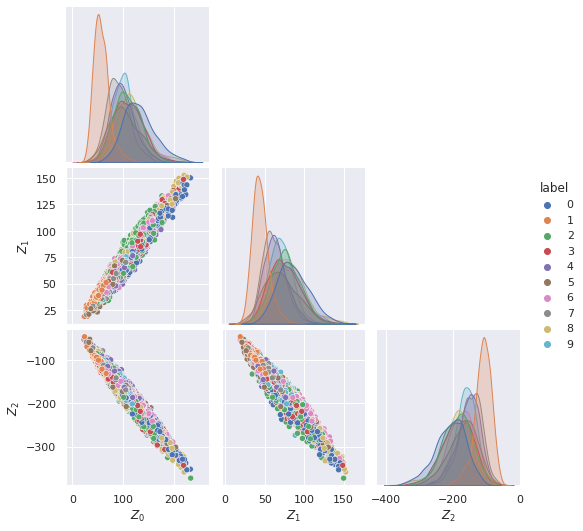

In [89]:
sns.pairplot(latent_df, hue='label', corner=True)
plt.show()